The temperature in the bottom of the Salish Sea for nowcast-green is much too cold. Can this impact the density and in turn the deep water renewal?

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import datetime
from dateutil import tz
import os
import pandas as pd

from salishsea_tools import (
    geo_tools,
    places,
    psu_tools,
    teos_tools,
    data_tools,
    tidetools,
)

from nowcast import analyze
from nowcast.figures import shared

%matplotlib inline

In [2]:
grid_B=nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_downonegrid.nc')
mesh_mask = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/mesh_mask_downbyone.nc')

In [3]:
t_o=datetime.datetime(2016,2,7); t_f = datetime.datetime(2016,7,6)

fnames = analyze.get_filenames(t_o, t_f, '1d', 'grid_T', '/results/SalishSea/nowcast-green/')

In [4]:
def get_onc_TS_time_series(station, t_o, t_f):
    """Grab the ONC temperature and salinity time series for a station between dates
    t_o and t_f. Return results as separate temperature and salinty data frames."""
    numdays = (t_f-t_o).days
    dates = [t_o + datetime.timedelta(days=num)
             for num in range(0, numdays+1)]
    sal_pd = pd.DataFrame({'time':[],
                           'data': []})
    temp_pd = pd.DataFrame({'time': [],
                            'data': []})
    station_code = places.PLACES[station]['ONC stationCode']
    for date in dates:
        onc_data = data_tools.get_onc_data(
            'scalardata', 'getByStation', os.environ['ONC_USER_TOKEN'],
            station=station_code,
            deviceCategory='CTD', sensors='salinity,temperature',
            dateFrom=data_tools.onc_datetime(date, 'utc'))
        try:
            ctd_data=data_tools.onc_json_to_dataset(onc_data)
            #quality control
            qc_sal = np.array(ctd_data.salinity.qaqcFlag)
            qc_temp = np.array(ctd_data.temperature.qaqcFlag)
            #average 
            sal_pd = sal_pd.append({'time': ctd_data.salinity.sampleTime.values[0],
                                    'data': ctd_data.salinity.values[qc_sal==1].mean()}, 
                                    ignore_index=True)
            temp_pd = temp_pd.append({'time': ctd_data.temperature.sampleTime.values[0],
                                      'data': ctd_data.temperature.values[qc_temp==1].mean()}, 
                                      ignore_index=True)
        except TypeError:
            print('No data for {} at {}'.format(date, station))
    return sal_pd, temp_pd

In [5]:
def get_model_time_series(station, fnames, grid_B, mesh_mask, nemo_36=True):
    """Retrieve the density, salinity and temperature time series at a station. 
    Time series is created from files listed in fnames"""
    if nemo_36:
        depth_var='gdept_0'
        depth_var_w = 'gdepw_0'
    else:
        depth_var='gdept'
        depth_var_w = 'gdepw'
    
    #station info
    lon = places.PLACES[station]['lon lat'][0]
    lat = places.PLACES[station]['lon lat'][1]
    depth = places.PLACES[station]['depth']
    
    # model corresponding locations and variables
    bathy, X, Y = tidetools.get_bathy_data(grid_B)
    j, i = geo_tools.find_closest_model_point(lon,lat,X,Y, land_mask=bathy.mask)
    model_depths = mesh_mask.variables[depth_var][0,:,j,i]
    tmask = mesh_mask.variables['tmask'][0,:,j,i]
    wdeps = mesh_mask.variables[depth_var_w][0,:,j,i]
    sal, time = analyze.combine_files(fnames,'vosaline','None',j,i)
    temp, time = analyze.combine_files(fnames,'votemper','None',j,i)
    
    # interpolate:
    sal_interp=np.array(
        [shared.interpolate_tracer_to_depths(
            sal[i,:],model_depths,depth,tmask,wdeps)
        for i in range(sal.shape[0])])
    temp_interp=np.array(
        [shared.interpolate_tracer_to_depths(
            temp[i,:],model_depths,depth,tmask,wdeps)
        for i in range(temp.shape[0])])
    
    # convert to psu for using density function
    if nemo_36:
        sal_interp = teos_tools.teos_psu(sal_interp)
    density = psu_tools.calculate_density(temp_interp, sal_interp)
    
    return density, sal_interp, temp_interp, time

In [6]:
rhos = {}
times = {}
sals={}
temps={}
stations = ['Central node', 'East node', 'Delta BBL node', 'Delta DDL node']
for station in stations:
    print(station)
    rhos[station],sals[station], temps[station], times[station] = get_model_time_series(station, fnames,
                                                                                        grid_B, mesh_mask)

Central node
East node
Delta BBL node
Delta DDL node


No data for 2016-05-02 00:00:00 at Central node
No data for 2016-04-07 00:00:00 at East node
No data for 2016-04-08 00:00:00 at East node
No data for 2016-04-09 00:00:00 at East node
No data for 2016-04-10 00:00:00 at East node
No data for 2016-04-11 00:00:00 at East node
No data for 2016-04-12 00:00:00 at East node
No data for 2016-04-13 00:00:00 at East node
No data for 2016-04-14 00:00:00 at East node
No data for 2016-04-15 00:00:00 at East node
No data for 2016-04-16 00:00:00 at East node
No data for 2016-04-17 00:00:00 at East node
No data for 2016-04-18 00:00:00 at East node
No data for 2016-04-19 00:00:00 at East node
No data for 2016-04-20 00:00:00 at East node
No data for 2016-04-21 00:00:00 at East node
No data for 2016-04-22 00:00:00 at East node
No data for 2016-04-23 00:00:00 at East node
No data for 2016-04-24 00:00:00 at East node
No data for 2016-04-25 00:00:00 at East node
No data for 2016-04-26 00:00:00 at East node
No data for 2016-04-27 00:00:00 at East node
No data

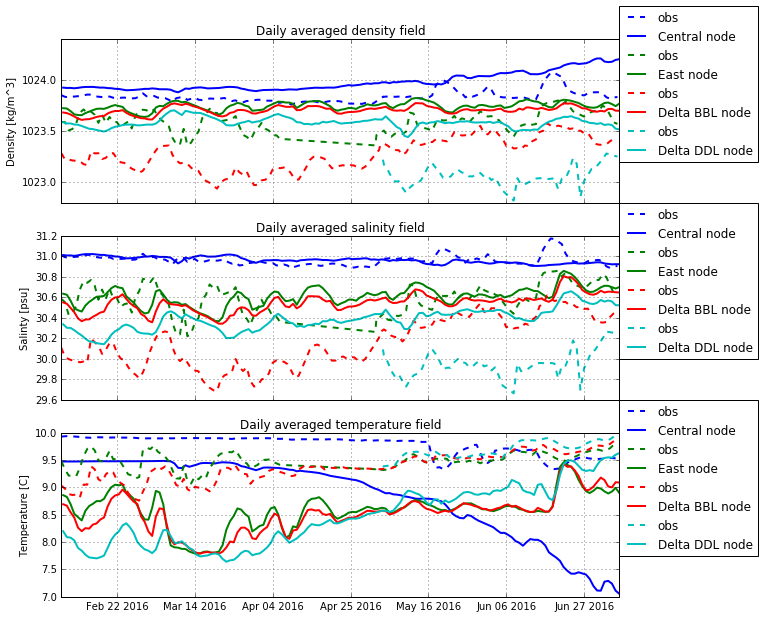

In [7]:
fig, axs = plt.subplots(3,1,figsize=(10,10), sharex=True)
colours = ['b', 'g', 'r', 'c']
variables = [rhos, sals, temps]
names = ['Density [kg/m^3]', 'Salinty [psu]', 'Temperature [C]']
titles = ['density', 'salinity', 'temperature']
for station, col in zip(stations, colours):
    obs_sal, obs_temp = get_onc_TS_time_series(station, t_o, t_f)
    obs_rho = pd.DataFrame({'time':[], 'data':[]})
    obs_rho.data = psu_tools.calculate_density(obs_temp['data'].values, obs_sal['data'].values )
    obs_rho.time = obs_temp.time
    obs = [obs_rho, obs_sal,obs_temp]
    for var, name, title, ax, ob in zip(variables, names, titles, axs, obs):
        ax.plot(ob.time, ob.data, '--',c=col, label='obs',lw=2)
        ax.plot(times[station], var[station], c=col, label=station,lw=2)
        ax.set_ylabel(name)
for ax, title in zip(axs,titles):
    ax.grid()
    ax.legend(loc=(1,0.25))
    ax.get_yaxis().get_major_formatter().set_useOffset(False)
    ax.set_title('Daily averaged {} field'.format(title))

** East renewal event in late June**
* Why did the temperature increase so much in model? Summer renewals typically bring in colder water. Could it be related to boundary conditions at JDF? I modified salinity but not temperature, although I believe there was a warm bias in June:
http://nbviewer.jupyter.org/urls/bitbucket.org/salishsea/analysis/raw/tip/Nancy/strat/comparisons/JuandeFucaBCs.ipynb 
* Compared to observatiobns, we are cold at East and above so maybe the warm spike is not that bizarre...
* Even so, the cold temperature at Central is making the density so high that I doubt we will renew this summer. A quick look at ONC State of the ocean plots suggests that observed density spikes at East node are typically less than .5 kg/m^3 during renweal events. http://www.oceannetworks.ca/in%C2%ADstal%C2%ADla%C2%ADtions/observatories/salish-sea/eastern-strait-georgia#SOO-SG-East


** DDL and BBL**
* It looks like we might start off salty at the DDL and BBL depths (107m, 143m)

** Note on QA/QC**
* Only used ONC data with qcflag =1, meaning data passed all tests. http://www.oceannetworks.ca/data-tools/data-quality
* I wonder if there is a way to get their 'cleaned' data through the api. The data on their plotting utility looks very different from what we download.

** Other notes**
* I started the comparison in February because we switched to TEOS-10 then...